Cassava Leaf Disease Classification - Data Augmentation

In [ ]:


# Download from Huggingface
!wget -q --show-progress https://huggingface.co/datasets/cayala/cassava/resolve/main/cassava.zip

# Extract to folder
!unzip -q cassava.zip

# Remove the zip file
!rm cassava.zip

# Extract imagery folder
!unzip -q cassava/images.zip -d cassava/images

# Remove imagery zip
!rm cassava/images.zip



cassava.zip         100%[===================>]   2.38G   122MB/s    in 15s     


Imports

In [ ]:
!pip install pytorch_lightning -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 64.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import pytorch_lightning as pl
from torch.nn import functional as F
from collections import defaultdict
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import models
import torch.nn as nn
import os
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
from torchvision.models import ResNet18_Weights
import matplotlib.pyplot as plt
from torchvision import transforms
import json
import numpy as np

In [ ]:
# Read split CSV + create a filepath column
cassava_df = pd.read_csv('cassava/cassava_split.csv')
cassava_df['filepath'] = cassava_df.image_id.apply(lambda x : f'./cassava/images/{x}')
cassava_df.head()

image_id  label    set                         filepath
0  1584105518.jpg      4  train  ./cassava/images/1584105518.jpg
1  4020462779.jpg      1  train  ./cassava/images/4020462779.jpg
2  3354881630.jpg      1  train  ./cassava/images/3354881630.jpg
3   388811074.jpg      4  train   ./cassava/images/388811074.jpg
4  4255258797.jpg      3  train  ./cassava/images/4255258797.jpg

In [ ]:
class CassavaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]

        x = Image.open(r.filepath).convert('RGB')
        y = torch.tensor(int(r.label), dtype=torch.long)

        if self.transform: x = self.transform(x)

        return x, y

In [ ]:
class CassavaDataModule(pl.LightningDataModule):
    def __init__(self, df, bs=64, n_workers=2):
        super().__init__()

        self.df = df
        self.bs = bs
        self.n_workers = n_workers
        #Classes
        with open("cassava/label_num_to_disease_map.json", "r") as f:
            label_map = json.load(f)
        self.classes = list(label_map.values())

        # ImageNet1K validation transforms
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        ])

    def setup(self, stage: str):
        self.train_ds = CassavaDataset(self.df.query('set == "train"'), transform=self.transform)
        self.val_ds = CassavaDataset(self.df.query('set == "val"'), transform=self.transform)
        self.test_ds = CassavaDataset(self.df.query('set == "test"'), transform=self.transform)


    def train_dataloader(self): return DataLoader(self.train_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=True)
    def val_dataloader(self): return DataLoader(self.val_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=False)
    def test_dataloader(self): return DataLoader(self.test_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=False)

In [ ]:
dm = CassavaDataModule(cassava_df, bs=64, n_workers=2)
dm.setup(None)
x, y = next(iter(dm.train_dataloader()))
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [ ]:
x.min()

tensor(-2.1179)

In [ ]:
class LightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, wd=0., discriminative_lr=None):
        super().__init__()
        self.model = model
        self.lr = lr
        self.wd = wd
        self.discriminative_lr = discriminative_lr # (lr, lr_mult)

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)

    def get_layer_wise_lr(self, lr, lr_mult):

        # Save layer names
        layer_names = []
        for idx, (name, param) in enumerate(self.model.named_parameters()):
            layer_names.append(name)
            print(f'{idx}: {name}')

        # Reverse layers
        layer_names.reverse()

        # placeholder
        parameters      = []
        prev_group_name = layer_names[0].split('.')[0]

        # store params & learning rates
        for idx, name in enumerate(layer_names):

            # parameter group name
            cur_group_name = name.split('.')[0]

            # update learning rate
            if cur_group_name != prev_group_name:
                lr *= lr_mult
            prev_group_name = cur_group_name

            # display info
            print('Using discriminative learning rates')
            print(f'{idx}: lr = {lr:.6f}, {name}')

            # append layer parameters
            parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                            'lr':     lr}]

        return parameters

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):

        return torch.optim.Adam(
            self.parameters() if self.discriminative_lr == None else self.get_layer_wise_lr(*self.discriminative_lr),
            lr=self.lr, weight_decay=self.wd)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)

        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['steps'] += 1

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['steps'] += 1

        return loss

    def on_train_epoch_end(self):
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.validation_step_outputs.clear()

In [ ]:
pl.seed_everything(seed=42, workers=True)

weights = ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

lightning_module = LightningModule(model, discriminative_lr=(1e-3, 0.9))

csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_ft_disc_lr")

model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

trainer = pl.Trainer(max_epochs=10, logger=csv_logger, callbacks=[model_checkpoint_callback])

data_module = CassavaDataModule(df=cassava_df, bs=64, n_workers=8)

trainer.fit(lightning_module, data_module)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


0: conv1.weight
1: bn1.weight
2: bn1.bias
3: layer1.0.conv1.weight
4: layer1.0.bn1.weight
5: layer1.0.bn1.bias
6: layer1.0.conv2.weight
7: layer1.0.bn2.weight
8: layer1.0.bn2.bias
9: layer1.1.conv1.weight
10: layer1.1.bn1.weight
11: layer1.1.bn1.bias
12: layer1.1.conv2.weight
13: layer1.1.bn2.weight
14: layer1.1.bn2.bias
15: layer2.0.conv1.weight
16: layer2.0.bn1.weight
17: layer2.0.bn1.bias
18: layer2.0.conv2.weight
19: layer2.0.bn2.weight
20: layer2.0.bn2.bias
21: layer2.0.downsample.0.weight
22: layer2.0.downsample.1.weight
23: layer2.0.downsample.1.bias
24: layer2.1.conv1.weight
25: layer2.1.bn1.weight
26: layer2.1.bn1.bias
27: layer2.1.conv2.weight
28: layer2.1.bn2.weight
29: layer2.1.bn2.bias
30: layer3.0.conv1.weight
31: layer3.0.bn1.weight
32: layer3.0.bn1.bias
33: layer3.0.conv2.weight
34: layer3.0.bn2.weight
35: layer3.0.bn2.bias
36: layer3.0.downsample.0.weight
37: layer3.0.downsample.1.weight
38: layer3.0.downsample.1.bias
39: layer3.1.conv1.weight
40: layer3.1.bn1.weight
4

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/call.py", line 49, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 598, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 1011, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 1053, in _run_stage
    self._run_sanity_check()
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 1082, in _run_sanity_check
    val_loop.run()
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/utilities.py", line 179, in _decorator
    return loop_run(self, *args, **kwargs)
         

TypeError: object of type 'NoneType' has no len()

In [ ]:
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0)

y_trues, y_hats = [], []

for (x, y_true) in iter(data_module.test_dataloader()):

    with torch.no_grad():
        y_hat_logits = model(x.cuda())
        y_hat = nn.Softmax(1)(y_hat_logits).argmax(1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true)

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f} | Macro-F1: {f1_score(y_trues, y_hats, average="macro"):.4f}')

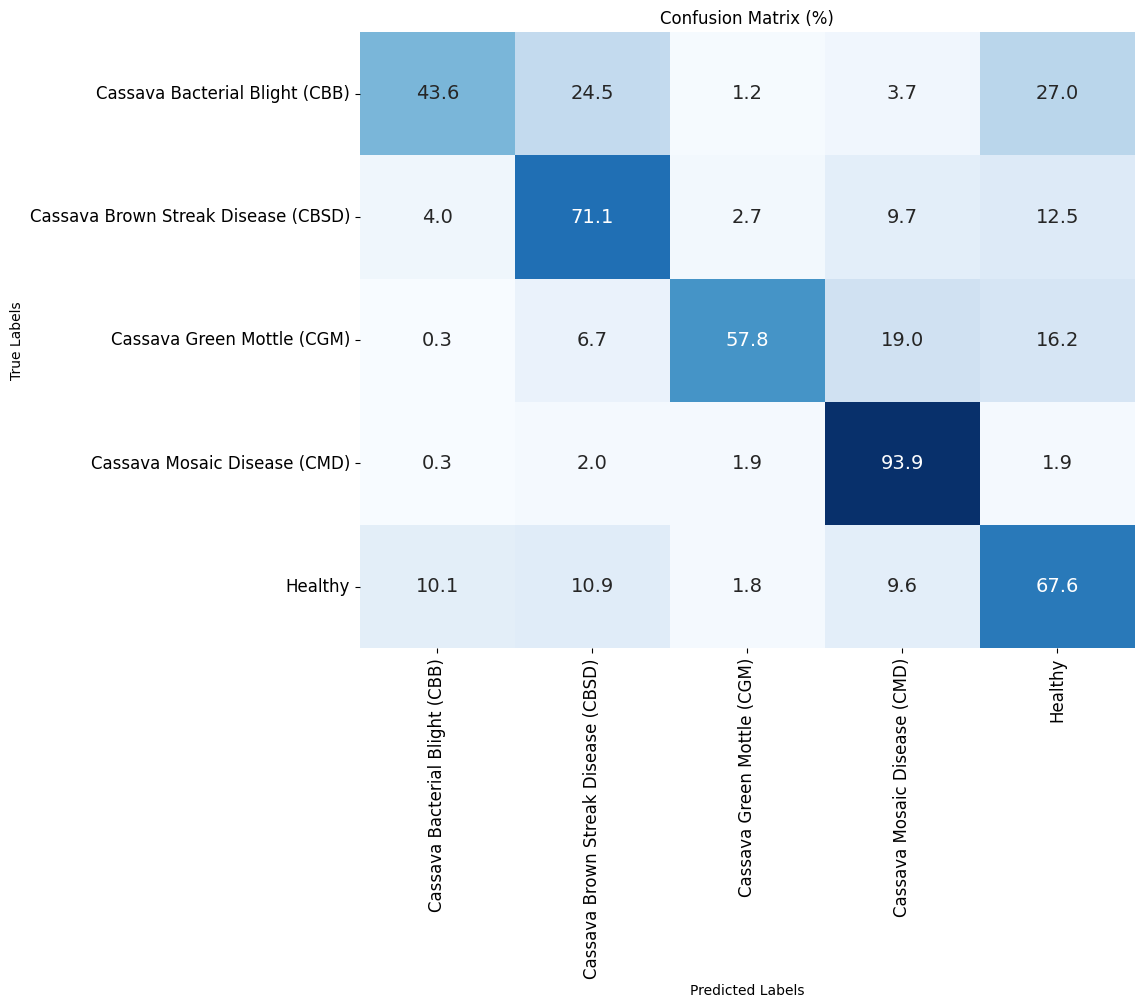

In [ ]:
import json
import numpy as np
# Suppose your dataset has 5 classes
with open("cassava/label_num_to_disease_map.json", "r") as f:
            label_map = json.load(f)
            classes = list(label_map.values())

class_labels = classes  # ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']


# Convert class labels to indices for confusion_matrix
labels_idx = list(range(len(class_labels)))  # [0,1,2,3,4]

cm = confusion_matrix(y_trues, y_hats, labels=labels_idx)

# Convert to percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 14})
plt.title("Confusion Matrix (%)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("confusion_matrix1.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
import pandas as pd
import json

# --- Short class names ---
short_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']

def display_examples_from_module(data_module, y_trues, y_hats, num_images=10):
    """
    Display correctly classified and misclassified images per class from a LightningDataModule
    Only for CBB and CGM
    """
    # Indices
    correct_idx = (y_trues == y_hats).nonzero(as_tuple=True)[0]
    misclassified_idx = (y_trues != y_hats).nonzero(as_tuple=True)[0]

    dataset = data_module.test_dataloader().dataset

    # Only display CBB (0) and CGM (2)
    for class_id in [0, 2]:
        class_name = short_names[class_id]

        # Filter indices for this class
        correct_class_idx = correct_idx[y_trues[correct_idx] == class_id][:num_images]
        misclassified_class_idx = misclassified_idx[y_trues[misclassified_idx] == class_id][:num_images]

        total_rows = 2
        total_cols = num_images
        fig, axes = plt.subplots(total_rows, total_cols, figsize=(2.5*total_cols, 5))
        fig.suptitle(f"Class: {class_name}\nTop: Correct | Bottom: Misclassified", fontsize=16, y=1.05)

        if total_cols == 1:
            axes = axes.reshape(2,1)

        # Correctly classified
        for i, idx in enumerate(correct_class_idx):
            img, _ = dataset[int(idx)]
            axes[0, i].imshow(img.permute(1,2,0))
            pred_label = y_hats[idx].item()
            axes[0, i].set_title(f"Pred: {short_names[pred_label]}", color='green', fontsize=9)
            axes[0, i].axis('off')

        for j in range(len(correct_class_idx), total_cols):
            axes[0,j].axis('off')

        # Misclassified
        for i, idx in enumerate(misclassified_class_idx):
            img, true_label = dataset[int(idx)]
            axes[1, i].imshow(img.permute(1,2,0))
            pred_label = y_hats[idx].item()
            axes[1, i].set_title(f"True: {short_names[int(true_label)]}\nPred: {short_names[int(pred_label)]}", color='red', fontsize=9)
            axes[1, i].axis('off')

        for j in range(len(misclassified_class_idx), total_cols):
            axes[1,j].axis('off')

        plt.subplots_adjust(wspace=0.1, hspace=0.25, top=0.8)
        plt.show()

# --- Example usage ---
display_examples_from_module(dm, y_trues, y_hats, num_images=10)


NameError: name 'y_trues' is not defined

## Define New Transformations


In [ ]:
from torchvision import transforms

# 1. Define a base_transform
base_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# 2. Create a random_hflip_transform
random_hflip_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
])

# 3. Create a random_vflip_transform
random_vflip_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.ToTensor(),
])

# 4. Create a random_rotation_transform
random_rotation_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
])

# 5. Create a color_jitter_transform
color_jitter_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.ToTensor(),
])

# 6. Store all defined transformations in a dictionary
augmentation_transforms = {
    'Base Transform': base_transform,
    'Random Horizontal Flip': random_hflip_transform,
    'Random Vertical Flip': random_vflip_transform,
    'Random Rotation': random_rotation_transform,
    'Color Jitter': color_jitter_transform,
}

print("Defined augmentation_transforms dictionary.")
print("Details of applied augmentation parameters:")

for name, transform_compose in augmentation_transforms.items():
    if name == 'Base Transform':
        print(f"- {name}: Only Resize(256), CenterCrop(224), ToTensor() applied.")
        continue

    # Find the specific augmentation transform within the Compose object
    augmentation_applied = False
    for t in transform_compose.transforms:
        if isinstance(t, transforms.RandomHorizontalFlip):
            print(f"- {name}: p={t.p}")
            augmentation_applied = True
            break
        elif isinstance(t, transforms.RandomVerticalFlip):
            print(f"- {name}: p={t.p}")
            augmentation_applied = True
            break
        elif isinstance(t, transforms.RandomRotation):
            # degrees can be a single int or a tuple
            if isinstance(t.degrees, (int, float)):
                print(f"- {name}: degrees={t.degrees}")
            else:
                print(f"- {name}: degrees={t.degrees[0]} to {t.degrees[1]}")
            augmentation_applied = True
            break
        elif isinstance(t, transforms.ColorJitter):
            print(f"- {name}: brightness={t.brightness}, contrast={t.contrast}, saturation={t.saturation}, hue={t.hue}")
            augmentation_applied = True
            break
    if not augmentation_applied:
        print(f"- {name}: No specific parameters identified for this custom transform.")

Defined augmentation_transforms dictionary.
Details of applied augmentation parameters:
- Base Transform: Only Resize(256), CenterCrop(224), ToTensor() applied.
- Random Horizontal Flip: p=1.0
- Random Vertical Flip: p=1.0
- Random Rotation: degrees=-30.0 to 30.0
- Color Jitter: brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.1, 0.1)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_transformations(transform_dict, sample_image_path, num_images=10):
    """
    Visualizes the effect of different transformations on a sample image.

    Args:
        transform_dict (dict): A dictionary of transformation names and their Compose objects.
        sample_image_path (str): The file path to a sample image.
        num_images (int): The number of times to apply and display each transformation.
    """
    original_image = Image.open(sample_image_path).convert('RGB')

    for name, transform in transform_dict.items():
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2.5, 3))
        fig.suptitle(f'{name} (Applied {num_images} times)', fontsize=16)

        for i in range(num_images):
            # Apply the transform. ToTensor() scales pixel values to [0, 1].
            # We need to convert it back to numpy array and transpose for imshow.
            transformed_image = transform(original_image)

            # If the transform doesn't include ToTensor() at the end, it might still be a PIL Image
            # Check type and convert accordingly for display
            if isinstance(transformed_image, torch.Tensor):
                # For PyTorch tensors, convert to numpy and transpose color channels
                img_to_display = transformed_image.numpy().transpose((1, 2, 0))
            else:
                # If it's still a PIL Image (e.g., if transform doesn't end with ToTensor),
                # just display it directly
                img_to_display = transformed_image

            axes[i].imshow(img_to_display)
            axes[i].set_title(f'Sample {i+1}')
            axes[i].axis('off')
        plt.show()

print("Defined visualize_transformations function.")

Defined visualize_transformations function.


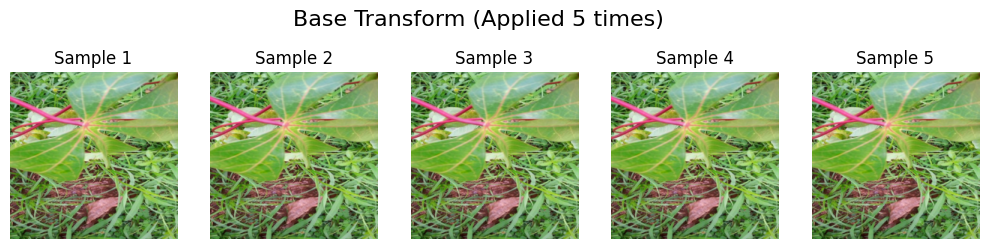

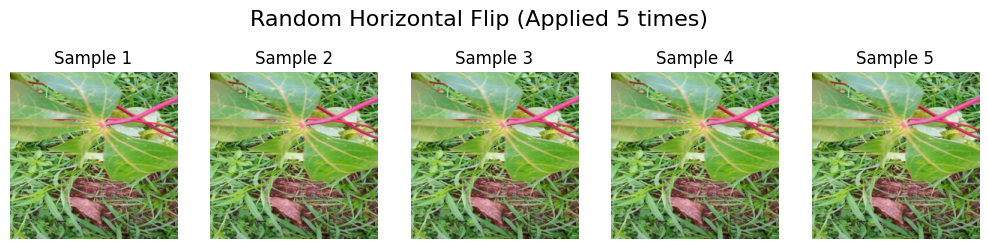

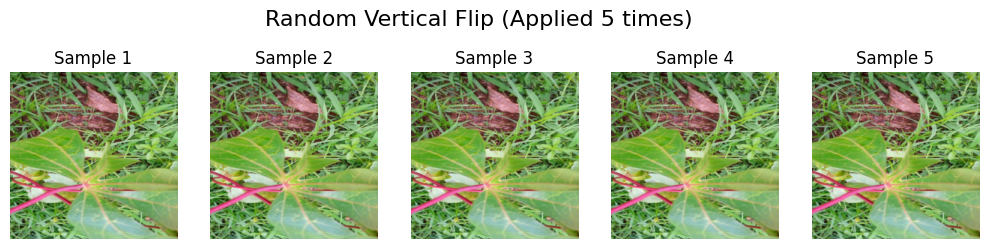

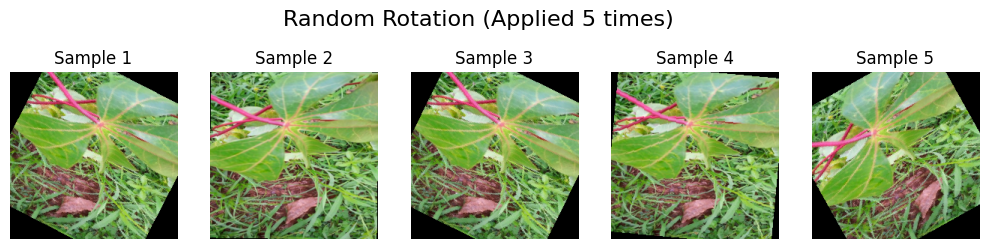

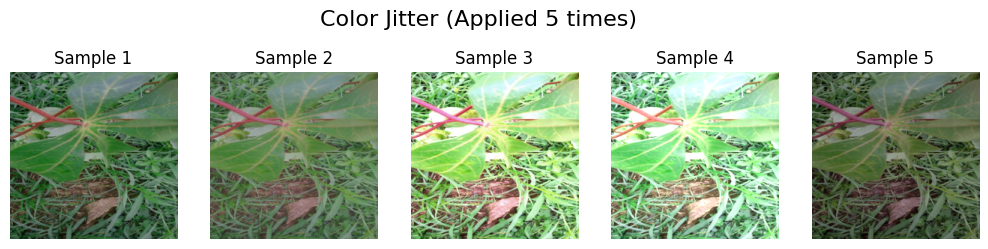

In [ ]:
sample_image_path = cassava_df.iloc[0]['filepath']
visualize_transformations(augmentation_transforms, sample_image_path, num_images=5)

# Task
Create diverse image augmentation pipelines including various combinations of `RandomHorizontalFlip`, `RandomVerticalFlip`, `RandomRotation`, `RandomResizedCrop`, `RandomAffine`, and `ColorJitter`, each followed by `ToTensor` and `Normalize` using ImageNet statistics. Then, define an image visualization function that correctly denormalizes images for display. Finally, apply and display 10 transformed versions for each defined pipeline on a sample image from the `cassava_df` to visually assess their effects.

## Define Diverse Transformation Pipelines

### Subtask:
Create a dictionary of `torchvision.transforms.Compose` objects, each representing a unique transformation pipeline combining various augmentation techniques with `ToTensor` and `Normalize` using ImageNet statistics.


**Reasoning**:
First, I'll define the ImageNet mean and standard deviation constants. Then, I will create a dictionary of diverse transformation pipelines as requested in the subtask instructions. Each pipeline will combine various augmentation techniques with `ToTensor` and `Normalize` using these ImageNet statistics. I will ensure each pipeline starts with `Resize(256)` and `CenterCrop(224)` and includes at least three distinct pipelines with different combinations and parameters.



In [ ]:
import torchvision.transforms as transforms

# 1. Define ImageNet mean and standard deviation
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# 2. Create a dictionary to store transformation pipelines
diverse_augmentation_pipelines = {}

# Base transformations always present
base_transforms = [
    transforms.Resize(256),
    transforms.CenterCrop(224),
]

# Common end transformations
end_transforms = [
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
]

# 3. and 4. Define diverse transformation pipelines

# Pipeline 1: Color Augmentation
diverse_augmentation_pipelines['Color Augmentation'] = transforms.Compose(
    base_transforms +
    [
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    ] +
    end_transforms
)

# Pipeline 2: Geometric Augmentation (Rotation + Random Resized Crop)
diverse_augmentation_pipelines['Geometric Augmentation'] = transforms.Compose(
    base_transforms +
    [
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=30),
        transforms.RandomHorizontalFlip(),
    ] +
    end_transforms
)

# Pipeline 3: Combined Augmentation (More Color Jitter + Affine + Vertical Flip)
diverse_augmentation_pipelines['Combined Augmentation'] = transforms.Compose(
    base_transforms +
    [
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=30),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    ] +
    end_transforms
)

# Pipeline 4: Only Normalization (No Augmentation)
diverse_augmentation_pipelines['No Augmentation (Normalized)'] = transforms.Compose(
    base_transforms +
    end_transforms
)

print("Defined diverse_augmentation_pipelines dictionary with 4 pipelines.")
print("IMAGENET_MEAN:", IMAGENET_MEAN)
print("IMAGENET_STD:", IMAGENET_STD)

Defined diverse_augmentation_pipelines dictionary with 4 pipelines.
IMAGENET_MEAN: [0.485, 0.456, 0.406]
IMAGENET_STD: [0.229, 0.224, 0.225]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

def visualize_transformations_denormalized(transform_dict, sample_image_path, num_images=10):
    """
    Visualizes the effect of different transformations on a sample image,
    correctly denormalizing images for display.

    Args:
        transform_dict (dict): A dictionary of transformation names and their Compose objects.
        sample_image_path (str): The file path to a sample image.
        num_images (int): The number of times to apply and display each transformation.
    """
    original_image = Image.open(sample_image_path).convert('RGB')

    # Convert ImageNet mean and std to tensors for denormalization
    mean_tensor = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    std_tensor = torch.tensor(IMAGENET_STD).view(3, 1, 1)

    for name, transform in transform_dict.items():
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2.5, 3))
        fig.suptitle(f'{name} (Applied {num_images} times)', fontsize=16)

        for i in range(num_images):
            transformed_image = transform(original_image)

            # Assuming the transformed_image is a PyTorch tensor after ToTensor() and Normalize()
            if isinstance(transformed_image, torch.Tensor):
                # Denormalize the image
                denormalized_image = transformed_image * std_tensor + mean_tensor

                # Clip values to [0, 1] as some denormalized pixels might fall outside due to floating point arithmetic
                denormalized_image = torch.clamp(denormalized_image, 0, 1)

                # Convert to numpy and transpose for matplotlib display (H, W, C)
                img_to_display = denormalized_image.numpy().transpose((1, 2, 0))
            else:
                # Fallback if somehow it's not a tensor (shouldn't happen with these pipelines)
                img_to_display = transformed_image

            axes[i].imshow(img_to_display)
            axes[i].set_title(f'Sample {i+1}')
            axes[i].axis('off')
        plt.show()

print("Defined visualize_transformations_denormalized function with denormalization logic.")

Defined visualize_transformations_denormalized function with denormalization logic.


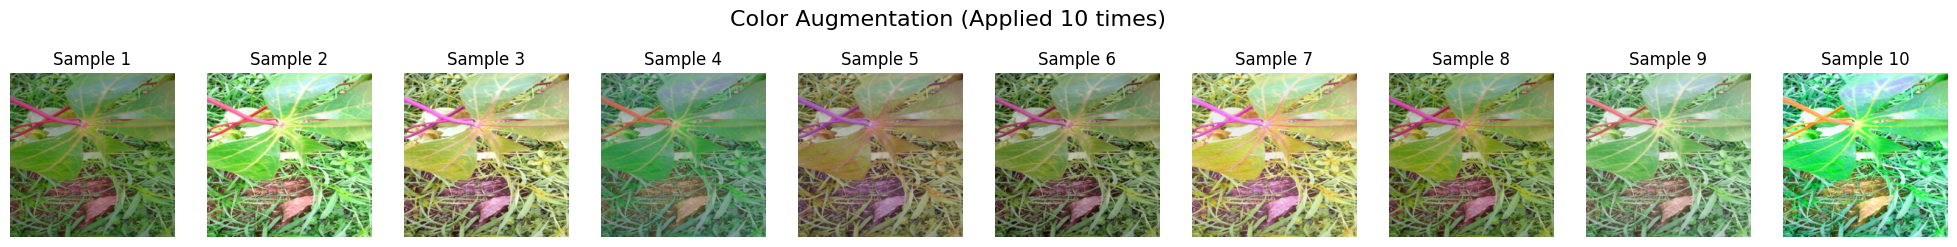

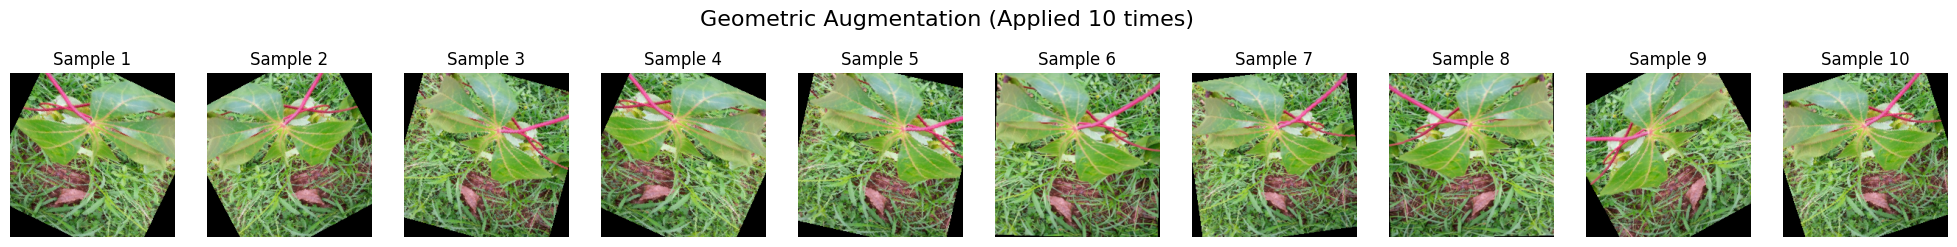

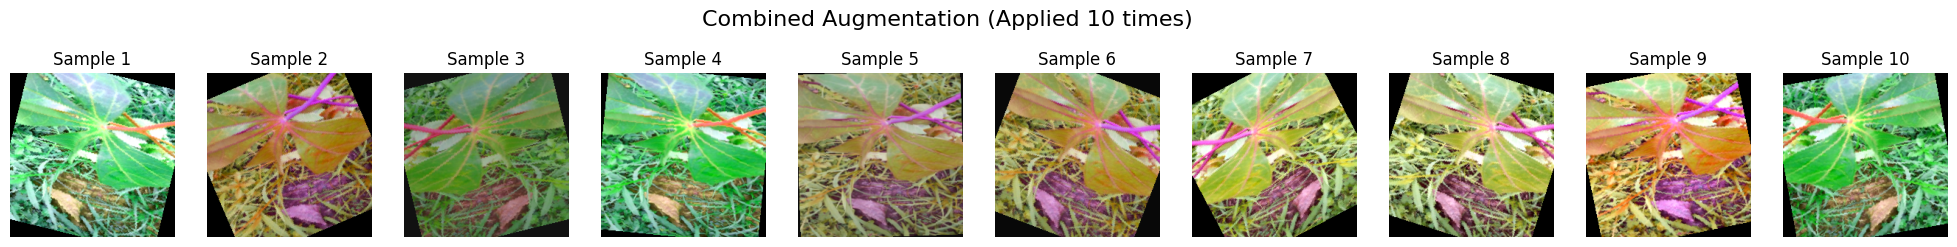

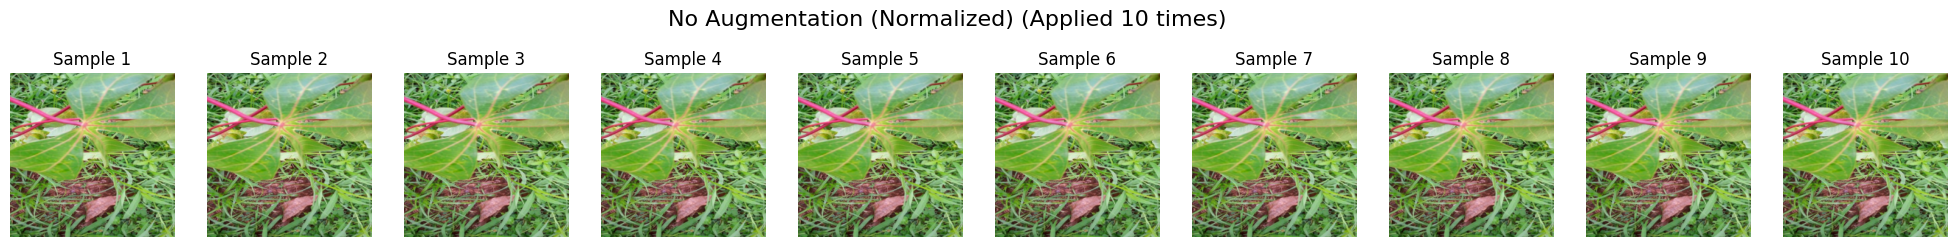

In [ ]:
sample_image_path = cassava_df.iloc[0]['filepath']
visualize_transformations_denormalized(diverse_augmentation_pipelines, sample_image_path, num_images=10)

# Training with Different Augmentation Pipelines

Train the model with each augmentation pipeline and compare results.

In [ ]:
# Create an augmented data module class
class AugmentedCassavaDataModule(pl.LightningDataModule):
    def __init__(self, df, train_transform, val_test_transform, bs=64, n_workers=2):
        super().__init__()
        self.df = df
        self.train_transform = train_transform
        self.val_test_transform = val_test_transform
        self.bs = bs
        self.n_workers = n_workers
        
        # Classes
        with open("cassava/label_num_to_disease_map.json", "r") as f:
            label_map = json.load(f)
        self.classes = list(label_map.values())

    def setup(self, stage: str):
        self.train_ds = CassavaDataset(self.df.query('set == "train"'), transform=self.train_transform)
        self.val_ds = CassavaDataset(self.df.query('set == "val"'), transform=self.val_test_transform)
        self.test_ds = CassavaDataset(self.df.query('set == "test"'), transform=self.val_test_transform)

    def train_dataloader(self): 
        return DataLoader(self.train_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=True)
    
    def val_dataloader(self): 
        return DataLoader(self.val_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=False)
    
    def test_dataloader(self): 
        return DataLoader(self.test_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=False)

print("Defined AugmentedCassavaDataModule class")

In [ ]:
# Define validation/test transform (same as baseline - no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Training configurations to compare
training_configs = {
    'No Augmentation (Baseline)': diverse_augmentation_pipelines['No Augmentation (Normalized)'],
    'Color Augmentation': diverse_augmentation_pipelines['Color Augmentation'],
    'Geometric Augmentation': diverse_augmentation_pipelines['Geometric Augmentation'],
    'Combined Augmentation': diverse_augmentation_pipelines['Combined Augmentation']
}

print(f"Defined {len(training_configs)} training configurations to compare")

In [ ]:
# Train models with different augmentation strategies
all_results = {}
all_models = {}
all_metrics = {}

for config_name, train_transform in training_configs.items():
    print(f"\n{'='*70}")
    print(f"Training with: {config_name}")
    print(f"{'='*70}\n")
    
    # Set seed for reproducibility
    pl.seed_everything(seed=42, workers=True)
    
    # Create fresh model
    weights = ResNet18_Weights.IMAGENET1K_V1
    model_config = models.resnet18(weights=weights)
    num_in_feat = model_config.fc.in_features
    model_config.fc = nn.Linear(num_in_feat, 5)
    
    # Create Lightning module
    lightning_module_config = LightningModule(model_config, discriminative_lr=(1e-3, 0.9))
    
    # Create logger
    log_name = config_name.replace(' ', '_').replace('(', '').replace(')', '').lower()
    csv_logger_config = CSVLogger(save_dir=os.getcwd(), name=f"cassava_{log_name}")
    
    # Create checkpoint callback
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss', mode='min', filename='best_valid_loss', 
        verbose=True, save_last=False
    )
    
    # Create trainer
    trainer_config = pl.Trainer(
        max_epochs=10, 
        logger=csv_logger_config, 
        callbacks=[checkpoint_callback]
    )
    
    # Create data module with augmentation
    data_module_config = AugmentedCassavaDataModule(
        df=cassava_df, 
        train_transform=train_transform,
        val_test_transform=val_test_transform,
        bs=64, 
        n_workers=8
    )
    
    # Train
    trainer_config.fit(lightning_module_config, data_module_config)
    
    # Load best model
    best_model = LightningModule.load_from_checkpoint(
        checkpoint_callback.best_model_path, 
        model=model_config
    )
    best_model.cuda(0)
    best_model.eval()
    
    # Test the model
    y_trues_config, y_hats_config = [], []
    
    for (x, y_true) in iter(data_module_config.test_dataloader()):
        with torch.no_grad():
            y_hat_logits = best_model(x.cuda())
            y_hat = nn.Softmax(1)(y_hat_logits).argmax(1)
            y_hat = y_hat.detach().cpu()
        
        y_hats_config.append(y_hat)
        y_trues_config.append(y_true)
    
    y_trues_config = torch.cat(y_trues_config)
    y_hats_config = torch.cat(y_hats_config)
    
    # Calculate metrics
    acc = accuracy_score(y_trues_config, y_hats_config)
    f1 = f1_score(y_trues_config, y_hats_config, average="macro")
    
    print(f"\n{config_name} Test Results:")
    print(f"Acc.: {acc:.4f} | Macro-F1: {f1:.4f}\n")
    
    # Store results
    all_results[config_name] = {
        'y_trues': y_trues_config,
        'y_hats': y_hats_config,
        'accuracy': acc,
        'f1': f1,
        'log_dir': trainer_config.logger.log_dir
    }
    all_models[config_name] = best_model
    all_metrics[config_name] = pd.read_csv(f'{trainer_config.logger.log_dir}/metrics.csv')

print(f"\n{'='*70}")
print("All training completed!")
print(f"{'='*70}")

## Compare Training Results

Visualize training/validation losses and test accuracy across all augmentation strategies.

In [ ]:
# Plot all training and validation losses in a single graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

colors = ['blue', 'green', 'orange', 'red']
linestyles = ['-', '--', '-.', ':']

# Plot training losses
for idx, (config_name, metrics_df) in enumerate(all_metrics.items()):
    metrics_df = metrics_df.groupby('epoch', as_index=False).first()
    ax1.plot(metrics_df['epoch'], metrics_df['train_loss'], 
             color=colors[idx], linestyle=linestyles[idx], 
             label=config_name, linewidth=2, marker='o', markersize=4)

ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Plot validation losses
for idx, (config_name, metrics_df) in enumerate(all_metrics.items()):
    metrics_df = metrics_df.groupby('epoch', as_index=False).first()
    ax2.plot(metrics_df['epoch'], metrics_df['val_loss'], 
             color=colors[idx], linestyle=linestyles[idx], 
             label=config_name, linewidth=2, marker='s', markersize=4)

ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Loss', fontsize=12)
ax2.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("augmentation_training_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Display test metrics comparison
results_summary = []
for config_name, results in all_results.items():
    results_summary.append({
        'Configuration': config_name,
        'Accuracy': results['accuracy'],
        'Macro-F1': results['f1']
    })

results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("=" * 70)
print("TEST RESULTS SUMMARY")
print("=" * 70)
print(results_df.to_string(index=False))
print("=" * 70)

In [ ]:
# Plot all four confusion matrices in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (config_name, results) in enumerate(all_results.items()):
    y_trues_cm = results['y_trues']
    y_hats_cm = results['y_hats']
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_trues_cm, y_hats_cm, labels=labels_idx)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Plot
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", 
                cbar=False, ax=axes[idx],
                xticklabels=class_labels, yticklabels=class_labels, 
                annot_kws={"size": 11})
    
    acc = results['accuracy']
    f1 = results['f1']
    axes[idx].set_title(f"{config_name}\nAcc: {acc:.4f} | F1: {f1:.4f}", 
                       fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xlabel("Predicted Labels", fontsize=11)
    axes[idx].set_ylabel("True Labels", fontsize=11)
    axes[idx].tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.savefig("augmentation_confusion_matrices.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Bar chart comparison of test metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

configs = [r['Configuration'] for r in results_summary]
accuracies = [r['Accuracy'] for r in results_summary]
f1_scores = [r['Macro-F1'] for r in results_summary]

# Accuracy bar chart
bars1 = ax1.bar(configs, accuracies, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'], 
                edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Test Accuracy by Augmentation Strategy', fontsize=14, fontweight='bold')
ax1.set_ylim([0.5, 1.0])
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=15)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# F1 Score bar chart
bars2 = ax2.bar(configs, f1_scores, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'],
                edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Macro-F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('Test Macro-F1 by Augmentation Strategy', fontsize=14, fontweight='bold')
ax2.set_ylim([0.5, 1.0])
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=15)

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig("augmentation_metrics_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Test Time Augmentation (TTA)

TTA applies multiple augmentations to test images and averages the predictions to improve model robustness.

In [ ]:
# Install ttach library
!pip install ttach -q

In [ ]:
import ttach as tta

# Create TTA transforms
tta_transforms = tta.Compose([
    tta.HorizontalFlip(),
    tta.VerticalFlip(),
    tta.Rotate90(angles=[0, 90, 180, 270]),
])

In [ ]:
# Wrap the model with TTA
tta_model = tta.ClassificationTTAWrapper(model.model, tta_transforms, merge_mode='mean')
tta_model.eval()
tta_model.cuda(0)

print("TTA model created with the following augmentations:")
print("- Horizontal Flip")
print("- Vertical Flip")
print("- Rotation (0°, 90°, 180°, 270°)")
print("\nMerge mode: mean (average predictions)")

In [ ]:
# Test TTA model on test dataset
y_trues_tta, y_hats_tta = [], []

print("Running TTA inference on test dataset...")
for batch_idx, (x, y_true) in enumerate(iter(data_module.test_dataloader())):
    
    with torch.no_grad():
        # TTA model returns logits averaged over all augmentations
        y_hat_logits = tta_model(x.cuda())
        y_hat = nn.Softmax(1)(y_hat_logits).argmax(1)
        y_hat = y_hat.detach().cpu()

    y_hats_tta.append(y_hat)
    y_trues_tta.append(y_true)
    
    if (batch_idx + 1) % 10 == 0:
        print(f"Processed {batch_idx + 1} batches...")

y_trues_tta = torch.cat(y_trues_tta)
y_hats_tta = torch.cat(y_hats_tta)

print(f'\n=== TTA Results ===')
print(f'Acc.: {accuracy_score(y_trues_tta, y_hats_tta):.4f} | Macro-F1: {f1_score(y_trues_tta, y_hats_tta, average="macro"):.4f}')
print(f'\n=== Baseline Results (for comparison) ===')
print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f} | Macro-F1: {f1_score(y_trues, y_hats, average="macro"):.4f}')

In [ ]:
# Confusion Matrix for TTA Results
cm_tta = confusion_matrix(y_trues_tta, y_hats_tta, labels=labels_idx)

# Convert to percentages
cm_tta_percent = cm_tta.astype('float') / cm_tta.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_tta_percent, annot=True, fmt=".1f", cmap="Blues", cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 14})
plt.title("Confusion Matrix with TTA (%)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("confusion_matrix_tta.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Compare predictions: Baseline vs TTA
differences = (y_hats != y_hats_tta).sum().item()
total = len(y_hats)

print(f"Total test samples: {total}")
print(f"Predictions changed with TTA: {differences} ({differences/total*100:.2f}%)")
print(f"Predictions unchanged: {total - differences} ({(total-differences)/total*100:.2f}%)")

# Find samples where TTA fixed incorrect predictions
baseline_wrong = (y_trues != y_hats)
tta_correct = (y_trues == y_hats_tta)
fixed_by_tta = baseline_wrong & tta_correct

print(f"\nSamples fixed by TTA: {fixed_by_tta.sum().item()}")

# Find samples where TTA made correct predictions incorrect
baseline_correct = (y_trues == y_hats)
tta_wrong = (y_trues != y_hats_tta)
broken_by_tta = baseline_correct & tta_wrong

print(f"Samples broken by TTA: {broken_by_tta.sum().item()}")
print(f"Net improvement: {fixed_by_tta.sum().item() - broken_by_tta.sum().item()} samples")

## Different TTA Configurations

Let's test different TTA merge modes and augmentation combinations.

In [ ]:
# Define different TTA configurations
tta_configs = {
    'HFlip Only': tta.Compose([tta.HorizontalFlip()]),
    'HFlip + VFlip': tta.Compose([tta.HorizontalFlip(), tta.VerticalFlip()]),
    'Rotations Only': tta.Compose([tta.Rotate90(angles=[0, 90, 180, 270])]),
    'All (HFlip + VFlip + Rotate)': tta.Compose([
        tta.HorizontalFlip(),
        tta.VerticalFlip(),
        tta.Rotate90(angles=[0, 90, 180, 270])
    ]),
    'Scale': tta.Compose([tta.Scale(scales=[1, 1.1, 1.2])]),
    'All + Scale': tta.Compose([
        tta.HorizontalFlip(),
        tta.VerticalFlip(),
        tta.Rotate90(angles=[0, 90, 180, 270]),
        tta.Scale(scales=[1, 1.1])
    ])
}

print(f"Defined {len(tta_configs)} TTA configurations to test")

In [ ]:
# Test different TTA configurations
tta_results = []

for config_name, tta_transform in tta_configs.items():
    print(f"\n{'='*60}")
    print(f"Testing: {config_name}")
    print(f"{'='*60}")
    
    # Create TTA model with current configuration
    tta_model_config = tta.ClassificationTTAWrapper(model.model, tta_transform, merge_mode='mean')
    tta_model_config.eval()
    tta_model_config.cuda(0)
    
    # Evaluate
    y_trues_config, y_hats_config = [], []
    
    for x, y_true in iter(data_module.test_dataloader()):
        with torch.no_grad():
            y_hat_logits = tta_model_config(x.cuda())
            y_hat = nn.Softmax(1)(y_hat_logits).argmax(1)
            y_hat = y_hat.detach().cpu()
        
        y_hats_config.append(y_hat)
        y_trues_config.append(y_true)
    
    y_trues_config = torch.cat(y_trues_config)
    y_hats_config = torch.cat(y_hats_config)
    
    # Calculate metrics
    acc = accuracy_score(y_trues_config, y_hats_config)
    f1 = f1_score(y_trues_config, y_hats_config, average="macro")
    
    tta_results.append({
        'Configuration': config_name,
        'Accuracy': acc,
        'Macro-F1': f1
    })
    
    print(f"Accuracy: {acc:.4f} | Macro-F1: {f1:.4f}")

# Display results summary
print(f"\n{'='*60}")
print("TTA CONFIGURATIONS SUMMARY")
print(f"{'='*60}")
tta_results_df = pd.DataFrame(tta_results)
tta_results_df = tta_results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
print(tta_results_df.to_string(index=False))

In [ ]:
# Visualize TTA configuration results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Accuracy
ax1.barh(tta_results_df['Configuration'], tta_results_df['Accuracy'], color='skyblue')
ax1.set_xlabel('Accuracy', fontsize=12)
ax1.set_title('TTA Configurations - Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlim([0.5, 1.0])
ax1.grid(axis='x', alpha=0.3)

# Add baseline accuracy
baseline_acc = accuracy_score(y_trues, y_hats)
ax1.axvline(baseline_acc, color='red', linestyle='--', linewidth=2, label=f'Baseline: {baseline_acc:.4f}')
ax1.legend()

# Plot Macro-F1
ax2.barh(tta_results_df['Configuration'], tta_results_df['Macro-F1'], color='lightcoral')
ax2.set_xlabel('Macro-F1 Score', fontsize=12)
ax2.set_title('TTA Configurations - Macro-F1', fontsize=14, fontweight='bold')
ax2.set_xlim([0.5, 1.0])
ax2.grid(axis='x', alpha=0.3)

# Add baseline F1
baseline_f1 = f1_score(y_trues, y_hats, average="macro")
ax2.axvline(baseline_f1, color='red', linestyle='--', linewidth=2, label=f'Baseline: {baseline_f1:.4f}')
ax2.legend()

plt.tight_layout()
plt.savefig("tta_configurations_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Final Comparison: Augmentation Training vs TTA

Compare the best augmentation training results with TTA applied to the baseline model.

In [ ]:
# Combine training augmentation results with TTA results
combined_comparison = []

# Add training augmentation results
for config_name, results in all_results.items():
    combined_comparison.append({
        'Method': f'{config_name} (Training)',
        'Type': 'Training Augmentation',
        'Accuracy': results['accuracy'],
        'Macro-F1': results['f1']
    })

# Add TTA results (from the TTA configurations tested earlier)
for result in tta_results:
    combined_comparison.append({
        'Method': f"{result['Configuration']} (TTA)",
        'Type': 'Test Time Augmentation',
        'Accuracy': result['Accuracy'],
        'Macro-F1': result['Macro-F1']
    })

combined_df = pd.DataFrame(combined_comparison)
combined_df = combined_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("=" * 90)
print("COMPREHENSIVE COMPARISON: TRAINING AUGMENTATION vs TEST TIME AUGMENTATION")
print("=" * 90)
print(combined_df.to_string(index=False))
print("=" * 90)

In [ ]:
# Visualize comprehensive comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Separate training aug and TTA
train_aug_df = combined_df[combined_df['Type'] == 'Training Augmentation']
tta_df = combined_df[combined_df['Type'] == 'Test Time Augmentation']

# Plot Accuracy comparison
x_positions_train = np.arange(len(train_aug_df))
x_positions_tta = np.arange(len(train_aug_df), len(train_aug_df) + len(tta_df))

bars1_acc = ax1.bar(x_positions_train, train_aug_df['Accuracy'], 
                    color='#3498db', edgecolor='black', linewidth=1.5,
                    label='Training Augmentation', alpha=0.8)
bars2_acc = ax1.bar(x_positions_tta, tta_df['Accuracy'], 
                    color='#e74c3c', edgecolor='black', linewidth=1.5,
                    label='Test Time Augmentation', alpha=0.8)

all_methods = list(train_aug_df['Method']) + list(tta_df['Method'])
ax1.set_xticks(range(len(all_methods)))
ax1.set_xticklabels(all_methods, rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Accuracy: Training Augmentation vs TTA', fontsize=14, fontweight='bold')
ax1.set_ylim([0.5, 1.0])
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1_acc:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8, rotation=0)
for bar in bars2_acc:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8, rotation=0)

# Plot Macro-F1 comparison
bars1_f1 = ax2.bar(x_positions_train, train_aug_df['Macro-F1'], 
                   color='#3498db', edgecolor='black', linewidth=1.5,
                   label='Training Augmentation', alpha=0.8)
bars2_f1 = ax2.bar(x_positions_tta, tta_df['Macro-F1'], 
                   color='#e74c3c', edgecolor='black', linewidth=1.5,
                   label='Test Time Augmentation', alpha=0.8)

ax2.set_xticks(range(len(all_methods)))
ax2.set_xticklabels(all_methods, rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Macro-F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('Macro-F1: Training Augmentation vs TTA', fontsize=14, fontweight='bold')
ax2.set_ylim([0.5, 1.0])
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1_f1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8, rotation=0)
for bar in bars2_f1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.savefig("final_comparison_training_vs_tta.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Create a heatmap showing performance across all methods
heatmap_data = combined_df.pivot_table(
    index='Method', 
    values=['Accuracy', 'Macro-F1']
).T

plt.figure(figsize=(16, 4))
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn', 
            cbar_kws={'label': 'Score'}, linewidths=0.5, 
            vmin=0.5, vmax=1.0, annot_kws={"size": 9})
plt.title('Performance Heatmap: All Methods Comparison', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Method', fontsize=12, fontweight='bold')
plt.ylabel('Metric', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig("performance_heatmap_all_methods.png", dpi=300, bbox_inches='tight')
plt.show()

## Key Findings Summary

In [ ]:
# Analysis and key findings
print("=" * 90)
print("KEY FINDINGS")
print("=" * 90)

# Best overall method
best_method = combined_df.iloc[0]
print(f"\n1. BEST OVERALL METHOD:")
print(f"   Method: {best_method['Method']}")
print(f"   Type: {best_method['Type']}")
print(f"   Accuracy: {best_method['Accuracy']:.4f}")
print(f"   Macro-F1: {best_method['Macro-F1']:.4f}")

# Best training augmentation
best_train_aug = train_aug_df.iloc[0]
print(f"\n2. BEST TRAINING AUGMENTATION:")
print(f"   Method: {best_train_aug['Method']}")
print(f"   Accuracy: {best_train_aug['Accuracy']:.4f}")
print(f"   Macro-F1: {best_train_aug['Macro-F1']:.4f}")

# Best TTA
best_tta = tta_df.iloc[0]
print(f"\n3. BEST TEST TIME AUGMENTATION:")
print(f"   Method: {best_tta['Method']}")
print(f"   Accuracy: {best_tta['Accuracy']:.4f}")
print(f"   Macro-F1: {best_tta['Macro-F1']:.4f}")

# Baseline performance
baseline_result = combined_df[combined_df['Method'].str.contains('No Augmentation')].iloc[0]
print(f"\n4. BASELINE (No Augmentation):")
print(f"   Accuracy: {baseline_result['Accuracy']:.4f}")
print(f"   Macro-F1: {baseline_result['Macro-F1']:.4f}")

# Improvement analysis
best_improvement_acc = best_method['Accuracy'] - baseline_result['Accuracy']
best_improvement_f1 = best_method['Macro-F1'] - baseline_result['Macro-F1']
print(f"\n5. IMPROVEMENT OVER BASELINE:")
print(f"   Accuracy improvement: {best_improvement_acc:+.4f} ({best_improvement_acc/baseline_result['Accuracy']*100:+.2f}%)")
print(f"   Macro-F1 improvement: {best_improvement_f1:+.4f} ({best_improvement_f1/baseline_result['Macro-F1']*100:+.2f}%)")

# Training Aug vs TTA comparison
avg_train_aug_acc = train_aug_df['Accuracy'].mean()
avg_tta_acc = tta_df['Accuracy'].mean()
print(f"\n6. AVERAGE PERFORMANCE:")
print(f"   Training Augmentation - Avg Accuracy: {avg_train_aug_acc:.4f}")
print(f"   Test Time Augmentation - Avg Accuracy: {avg_tta_acc:.4f}")
print(f"   Difference: {avg_tta_acc - avg_train_aug_acc:+.4f}")

print("\n" + "=" * 90)